# Ephemeral Keys using Hierarchical Deterministic (HD) Scheme

Tony Yu Zhao, Dec. 6th, 2018

## Abstract

Cryptocurrency's Hierarchical Deterministic (HD) key schemes used in wallets may be of interest to generate unique ephermeral keys for encrypting each individual message (Kafka records) while providing forward and backward secrecy.

A master private key is generated from a mnemonic and stored safely at the agent that needs to decrypt the message while the associated public key can be passed to the agents producing the messages. For each deterministic child/grandchild of this public key, the consuming agent is able to decrypt using a single master private key. Additional firewalls can be added to protect this private key as described by the Hardened Key Derivation below.

Below is a quick notebook demonstrating this scheme ...

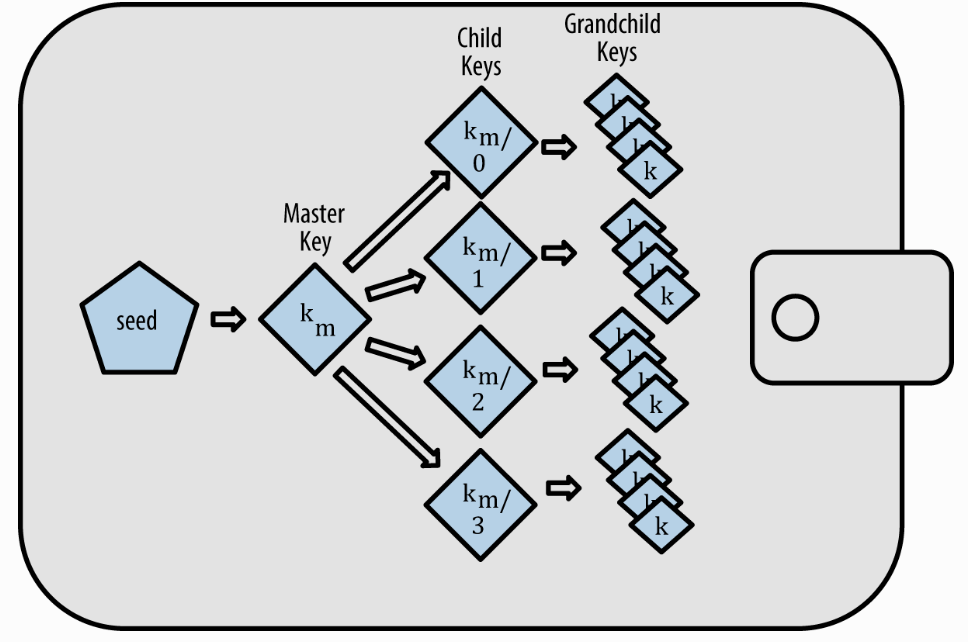

In [271]:
Image(filename="fig1.png", width=640, height=480)

## Imports

In [173]:
import sys

In [174]:
sys.path.remove('/Users/tonyyuzhao/Development/PythonProjects/cryptotools')

In [175]:
sys.path.append('/Users/tonyyuzhao/Development/PythonProjects/cryptotools')
sys.path

['/Users/tonyyuzhao/Development/JupyterNotebooks/crypto',
 '/anaconda3/envs/crypto/lib/python37.zip',
 '/anaconda3/envs/crypto/lib/python3.7',
 '/anaconda3/envs/crypto/lib/python3.7/lib-dynload',
 '',
 '/anaconda3/envs/crypto/lib/python3.7/site-packages',
 '/anaconda3/envs/crypto/lib/python3.7/site-packages/IPython/extensions',
 '/Users/tonyyuzhao/.ipython',
 '/Users/tonyyuzhao/Development/PythonProjects/cryptotools']

In [178]:
import hashlib
from btctools import Xprv
from ecies import encrypt, decrypt

In [267]:
from IPython.display import Image
from IPython.core.display import HTML

## Seed

Generate private master key (m) from mnemonic ...

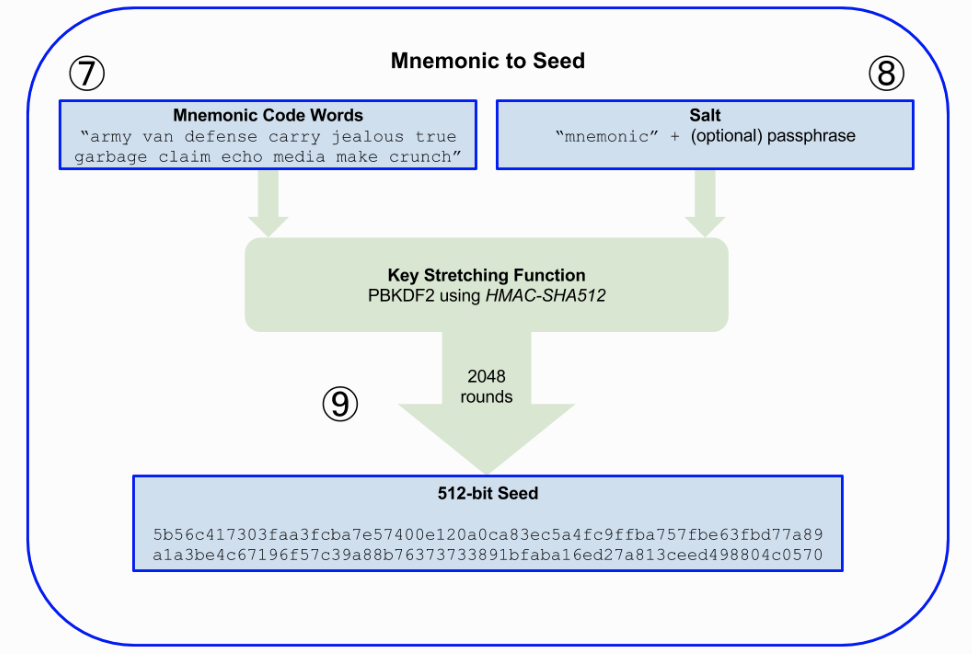

In [272]:
Image(filename="fig2.png", width=640, height=480)

In [123]:
m = Xprv.from_mnemonic('abandon abandon abandon abandon abandon abandon abandon abandon abandon abandon abandon about')
m

Xprv(path=m, key=Kx2nc8CerNfcsutaet3rPwVtxQvXuQTYxw1mSsfFHsWExJ9xVpLf)

Store the private master key (m) somewhere safe; generate public master key (M) from private master key (m) ...

In [179]:
M = m.to_xpub()
M

Xpub(path=M, key=03d902f35f560e0470c63313c7369168d9d7df2d49bf295fd9fb7cb109ccee0494)

This public master key (M) is made available for publicly ...

## Private Key Derivation

Using the private master key (m) we can derive any child private key (p) ...

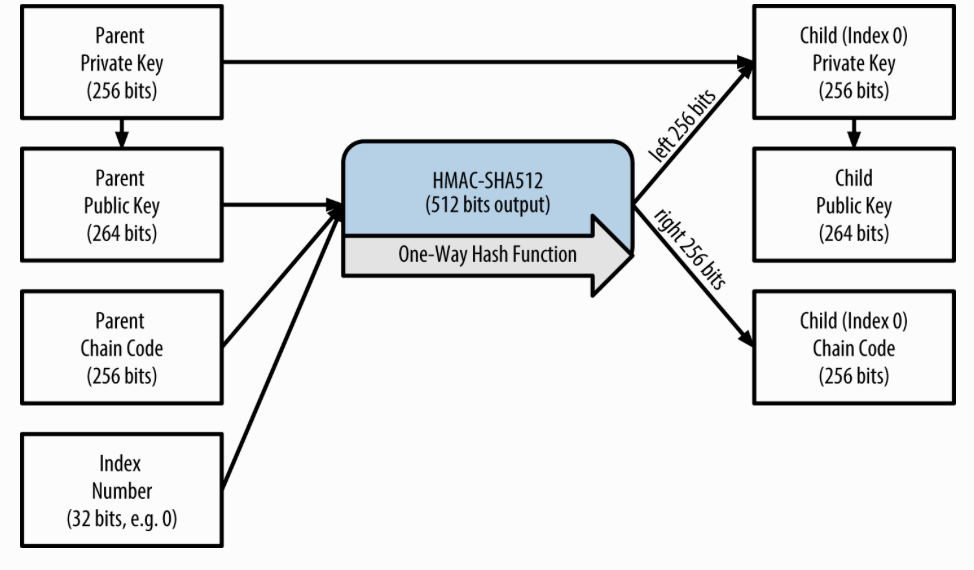

In [275]:
Image(filename="fig4.png", width=640, height=480)

In [255]:
p = m/0/0/1
p

Xprv(path=m/0/0/1, key=L15REvT4Z9Q4AbvzBaTuz2vhperHUAbnTouCu2CBgPUgVjUYzbnd)

Convert to hex ...

In [256]:
xprv = p.key.hex()
xprv

'731573db19bfd58d896e982ca68728ed927197757b93f2fd40d26129c7184512'

## Public Key Derivation

Generate the public key (P) for a specific path ...

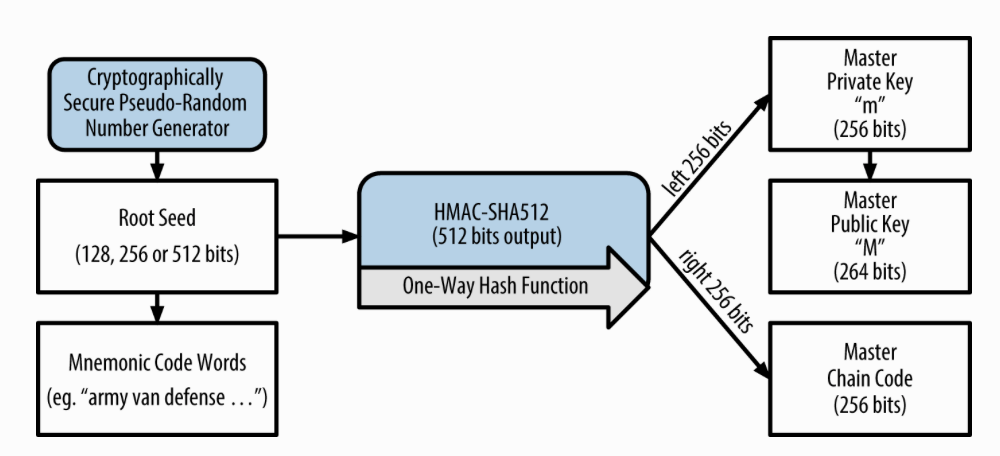

In [273]:
Image(filename="fig3.png", width=640, height=480)

In [252]:
P = M/0/0/1
P

Xpub(path=M/0/0/1, key=0350d801e5faf5cc96dc275996ab4e9fd88e52e32c95f3989b9349cce704ea41e6)

Convert to hex ...

In [253]:
xpub = P.key.hex()
xpub

'0450d801e5faf5cc96dc275996ab4e9fd88e52e32c95f3989b9349cce704ea41e6d1f67e4fb447095db9eb41d44a374720979e1ca514d99a145328be991591520f'

This can also be derived from the private key (p) ...

In [277]:
p.to_xpub() == P

True

## Hardened Key Derivation

“The ability to derive a branch of public keys from an xpub is very useful, but it comes with a potential risk. Access to an xpub does not give access to child private keys. However, because the xpub contains the chain code, if a child private key is known, or somehow leaked, it can be used with the chain code to derive all the other child private keys. A single leaked child private key, together with a parent chain code, reveals all the private keys of all the children. Worse, the child private key together with a parent chain code can be used to deduce the parent private key.
To counter this risk, HD wallets use an alternative derivation function called hardened derivation, which “breaks” the relationship between parent public key and child chain code. The hardened derivation function uses the parent private key to derive the child chain code, instead of the parent public key. This creates a “firewall” in the parent/child sequence, with a chain code that cannot be used to compromise a parent or sibling private key.”

Excerpt From: Andreas M.  Antonopoulos. “Mastering Bitcoin.” iBooks. 

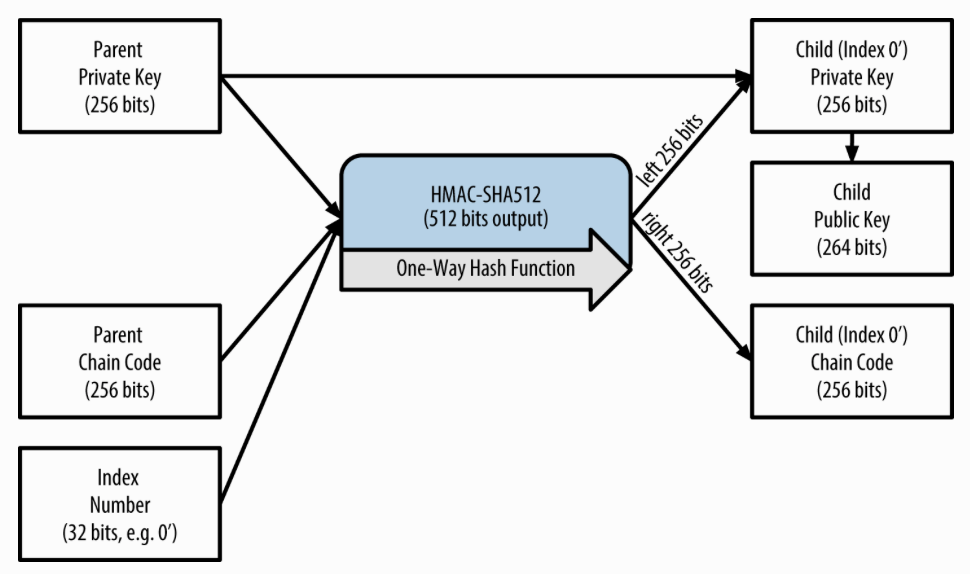

In [276]:
Image(filename="fig5.png", width=640, height=480)

In [297]:
m_ = m/0.0
m_

Xprv(path=m/0h, key=L3g1BuZkLzTakjRS4fBp2j42dmwndyPkpowrnPsZhMXwnC3jJxsT)

In [298]:
try:
    M_ = M/0.0
except Exception as e:
    print(e)

Cannot derive a hardened key from an extended public key


We can get the public key from this hardened master private key (m_) which firewalls off our seed and private master key (m) ...

In [299]:
M_ = m_.to_xpub()

In [301]:
(m_/0/0/1).to_xpub() == M_/0/0/1

True

In [306]:
try:
    M/0.0/0/0/1
except Exception as e:
    print(e)

Cannot derive a hardened key from an extended public key


## Implementation

A quick and dirty example showing how we can using hardened key derivation ...

In [317]:
class Sender:
    def __init__(self, M):
        self.M = M
    def encrypt(self, topic, date, msg_id, msg):
        P = self.M/topic/date/msg_id
        return encrypt(P.key.hex(), msg)

In [318]:
class Receiver:
    def __init__(self, m):
        self.m = m
    def decrypt(self, topic, date, msg_id, msg):
        p = self.m/0.0/topic/date/msg_id
        return decrypt(p.key.hex(), msg)

In [319]:
def intdigest(s):
    return int(hashlib.sha256(s.encode()).hexdigest(), 16) % (10 ** 8)

In [326]:
m = Xprv.from_mnemonic('abandon abandon abandon abandon abandon abandon abandon abandon abandon abandon abandon about')
m_ = m/0.0
M_ = m_.to_xpub()

In [328]:
alice = Sender(M_)
bob = Receiver(m)

Set some determinstic fields for a specific child key ...

In [329]:
topic = intdigest('foo')
date = 20190101
msg_id = 100

In [330]:
payload = alice.encrypt(topic, date, msg_id, b'hello world!')

In [331]:
bob.decrypt(topic, date, msg_id, payload)

b'hello world!'

The End